# US market analysis

## Import and cleaning data

### Import data ship price border

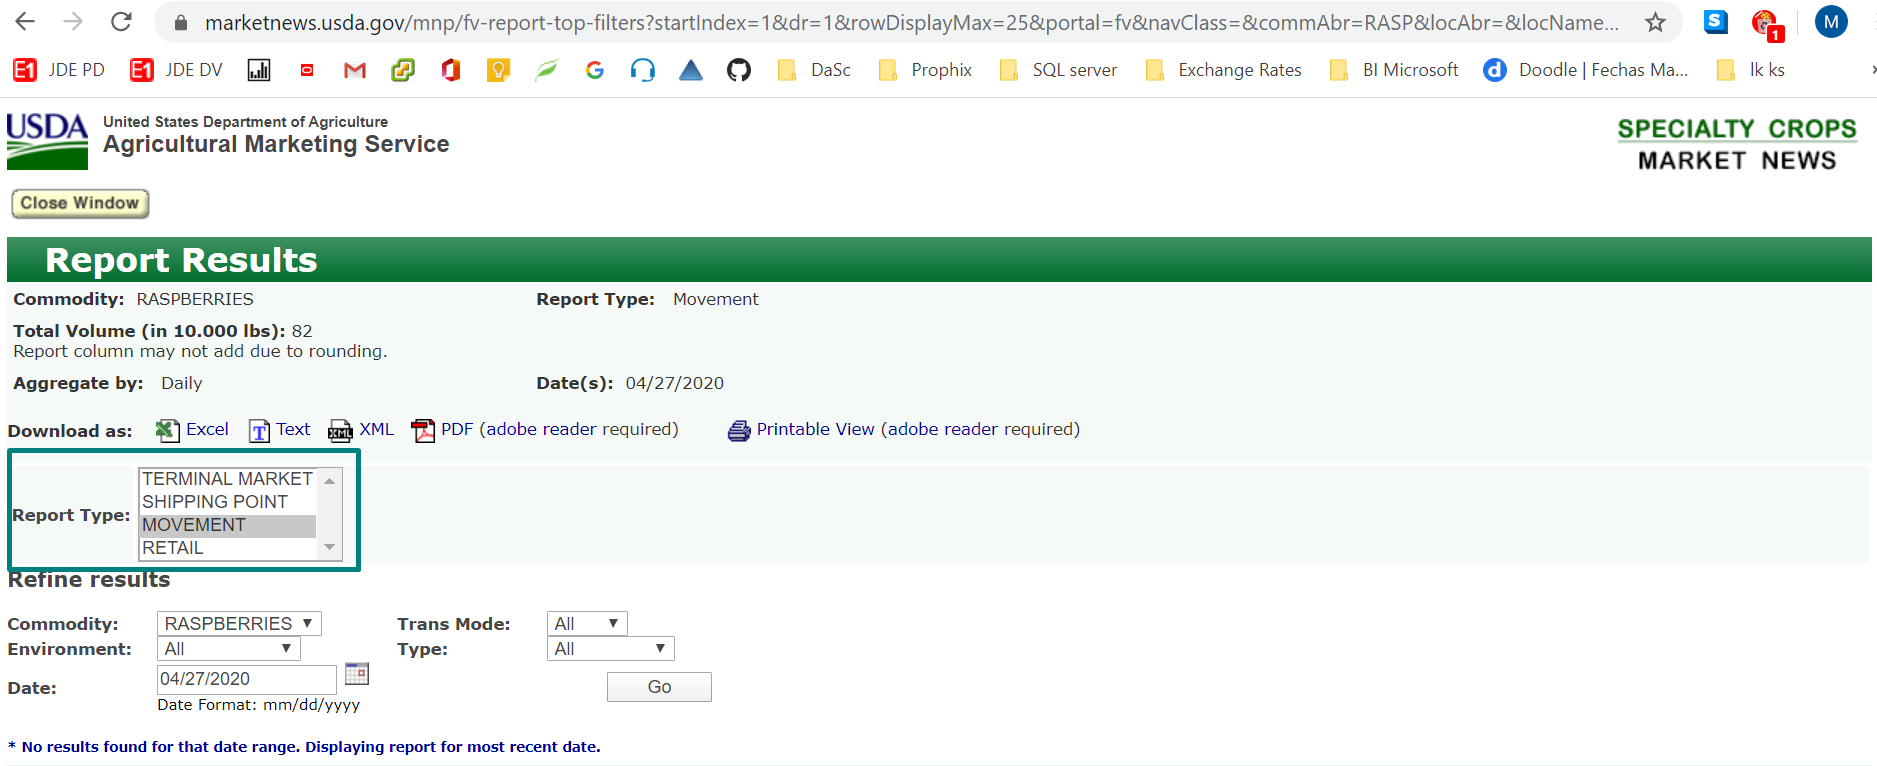

In [97]:
from IPython.display import Image
Image("Data/Website.png")

In [98]:
#crop = 'BLUEBERRIES'
#conv_package_un = 72 * 0.0283495
#crop_abb = 'BLUBY'
#lb_to_kg = 0.453592

In [99]:
#crop = 'RASPBERRIES'
#crop_abb = 'RASP'
#conv_package_un = 72 * 0.0283495
#lb_to_kg = 0.453592 #0.0283495*72

In [100]:
crop = 'STRAWBERRIES'
crop_abb = 'STRBY'
conv_package_un = 8 * 0.453592
lb_to_kg = 0.453592 #0.0283495*72

In [101]:
# Importing libraries 
import pandas as pd 
from datetime import date

# Setting dates
# Date from
fday = '01'
fmonth = '01'
fyear = '2017'

# Date to : current date data to collect updated information
tday = date.today().strftime('%d')
tmonth = date.today().strftime('%m')
tyear = date.today().strftime('%Y')

# URL for accessing prices
USprices = f"https://www.marketnews.usda.gov/mnp/fv-report-top-filters\
?&commAbr={crop_abb}&varName=&locAbr=&repType=shipPriceDaily\
&navType=byComm&locName=&navClass=&type=shipPrice&dr=1&volume=&commName={crop}&navClass,=&portal=fv&region=\
&repDate={fmonth}%2F{fday}%2F{fyear}&endDate={tmonth}%2F{tday}%2F{tyear}&format=excel&rebuild=false"
    

# Assign the table data in html format to a Pandas dataframe
table =  pd.read_html(USprices,header=0,parse_dates=['Date'])[0]
  
# Store the dataframe in Excel file to avoid html tags and save data source file
file_path = f'./Data/{crop}/USMXprices.xls'
table.to_excel(file_path) 

# Read the Excel in a Pandas dataframe
prices = pd.DataFrame()
prices = pd.read_excel(file_path\
                    ,header=0
                    ,usecols= (['Commodity Name',\
                    'City Name',\
                    'Package',\
                    'Date',\
                    'Low Price',\
                    'High Price',\
                    'Mostly Low',\
                    'Mostly High',\
                    'Season',\
                    'Type']))

### Analyize data

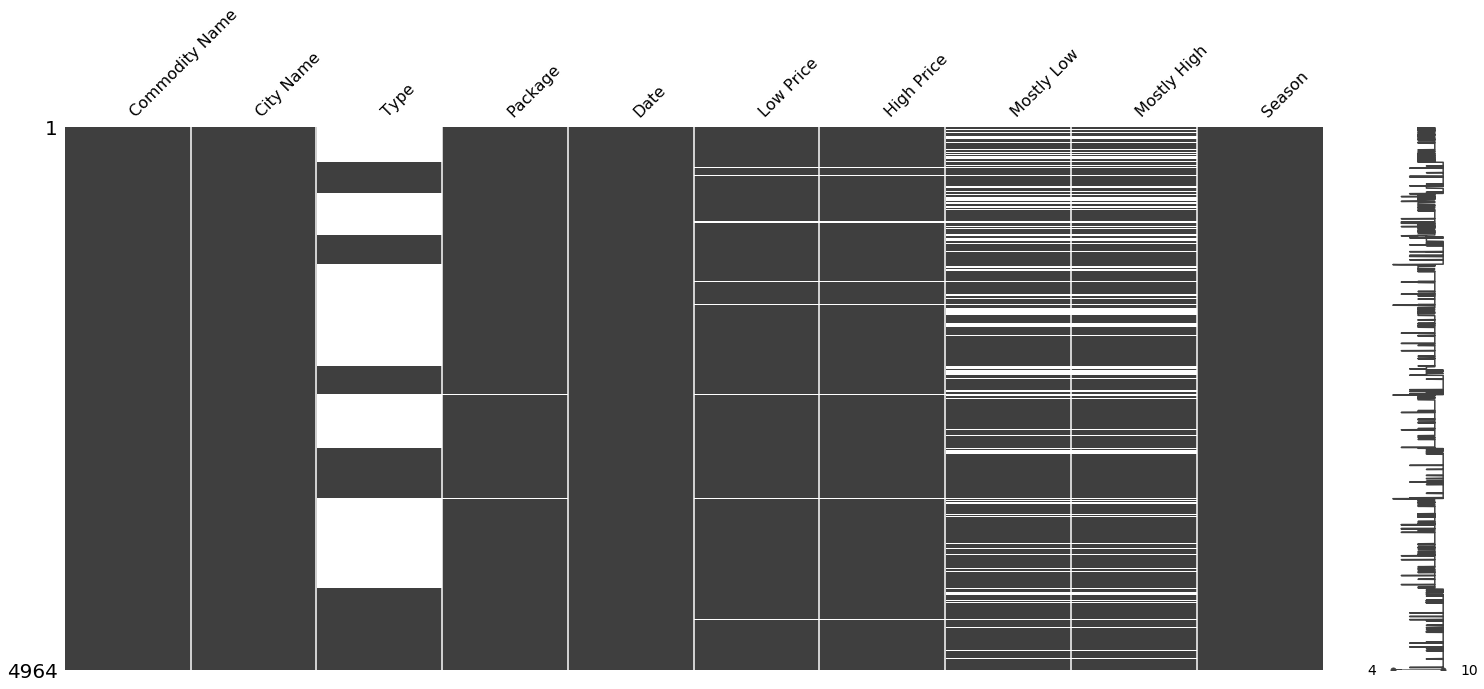

In [102]:
import missingno as msno
msno.matrix(prices)

In [103]:
prices.groupby('City Name')['Date'].nunique()

City Name
CENTRAL FLORIDA                       325
EASTERN NORTH CAROLINA                 77
MEXICO CROSSINGS THROUGH OTAY MESA    310
MEXICO CROSSINGS THROUGH TEXAS        367
OXNARD DISTRICT CALIFORNIA            561
SALINAS-WATSONVILLE CALIFORNIA        487
SANTA MARIA CALIFORNIA                686
Name: Date, dtype: int64

### Cleanance

<ul>
<li><input type="checkbox" disabled> Keep only imports from Mexico
<li><input type="checkbox" disabled> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

In [104]:
prices = prices[(prices['City Name'].astype(str).str[:6] == 'MEXICO') \
       & (prices['Low Price'].notnull()) & (prices['High Price'].notnull()) \
       & (prices['Type'] != 'Organic')].groupby('Date')['Low Price','High Price'].agg('mean').reset_index()

In [105]:
#prices = prices[(prices['City Name']=='MEXICO CROSSINGS THROUGH ARIZONA, CALIFORNIA AND TEXAS') \
       #& (prices['Low Price'].notnull()) & (prices['High Price'].notnull())]

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

In [106]:
prices['Avg Price'] = prices[['Low Price','High Price']].mean(axis=1)

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled checked> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

In [107]:
prices.head()

,Date,Low Price,High Price,Avg Price
0,2017-01-03,9.0,10.0,9.50
1,2017-01-04,10.5,12.0,11.25
2,2017-01-05,10.5,12.0,11.25
3,2017-01-06,11.0,12.0,11.50
4,2017-01-09,11.0,13.0,12.00


In [108]:
prices = prices[['Date','Low Price','High Price','Avg Price']]

In [109]:
#prices.drop(axis=1, columns=['Low Price','High Price','City Name','Package','Mostly Low','Mostly High','Commodity Name','Season'],inplace=True)

In [110]:
prices.set_index('Date',inplace=True)

In [111]:
prices_complete = prices.resample('D').fillna('nearest')

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled checked> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled checked> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled checked> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

### Import data movement quantities

In [112]:
# URL for accessing quantities
USquantity =f"https://www.marketnews.usda.gov/mnp/fv-report-top-filters?\
&commAbr={crop_abb}&varName=&locAbr=&repType=movementDaily\
&navType=byComm&locName=&navClass=&navClass=&type=movement&dr=1\
&volume=&commName={crop}&portal=fv&region=\
&repDate={fmonth}%2F{fday}%2F{fyear}&endDate={tmonth}%2F{tday}%2F{tyear}&format=excel&rebuild=false"
    
  
# Assign the table data in html format to a Pandas dataframe
table =  pd.read_html(USquantity,header=0,parse_dates=['Date'])[0]
  
# Store the dataframe in Excel file to avoid html tags and save data source file
file_path = f'./Data/{crop}/USMXquantity.xls'
table.to_excel(file_path) 

# Read the Excel in a Pandas dataframe
quantity = pd.DataFrame()
quantity = pd.read_excel(file_path\
                    ,header=0)

### Analyize data

In [113]:
quantity.head()

,Unnamed: 0,Commodity Name,Origin Name,Type,Package,Variety,Date,District,10000lb units,Trans Mode,Package Count,Car/Van Count,Season,Environment,Import/Export,Adjustments
0,0,STRAWBERRIES,ARGENTINA,NaN,NaN,NaN,2019-09-14,IMPORTS THROUGH BROOKLYN (NYC),5,Boat,NaN,NaN,2019,NaN,Import,week ending amount
1,1,STRAWBERRIES,ARGENTINA,NaN,NaN,NaN,2019-10-19,IMPORTS THROUGH PHILADELPHIA-CAMDEN,22,Boat,NaN,NaN,2019,NaN,Import,added for week ending 10/19/2019 on 10/29/2019
2,2,STRAWBERRIES,ARGENTINA,NaN,NaN,NaN,2019-10-26,IMPORTS THROUGH PHILADELPHIA-CAMDEN,10,Boat,NaN,NaN,2019,NaN,Import,added for week ending 10/26/2019 on 11/04/2019
3,3,STRAWBERRIES,ARGENTINA,NaN,NaN,NaN,2019-11-09,IMPORTS THROUGH NEW YORK JFK AIRPORT,0,Air,NaN,NaN,2019,NaN,Import,week ending amount
4,4,STRAWBERRIES,ARGENTINA,NaN,NaN,NaN,2019-12-21,IMPORTS THROUGH OAKLAND,10,Boat,NaN,NaN,2019,NaN,Import,week ending amount


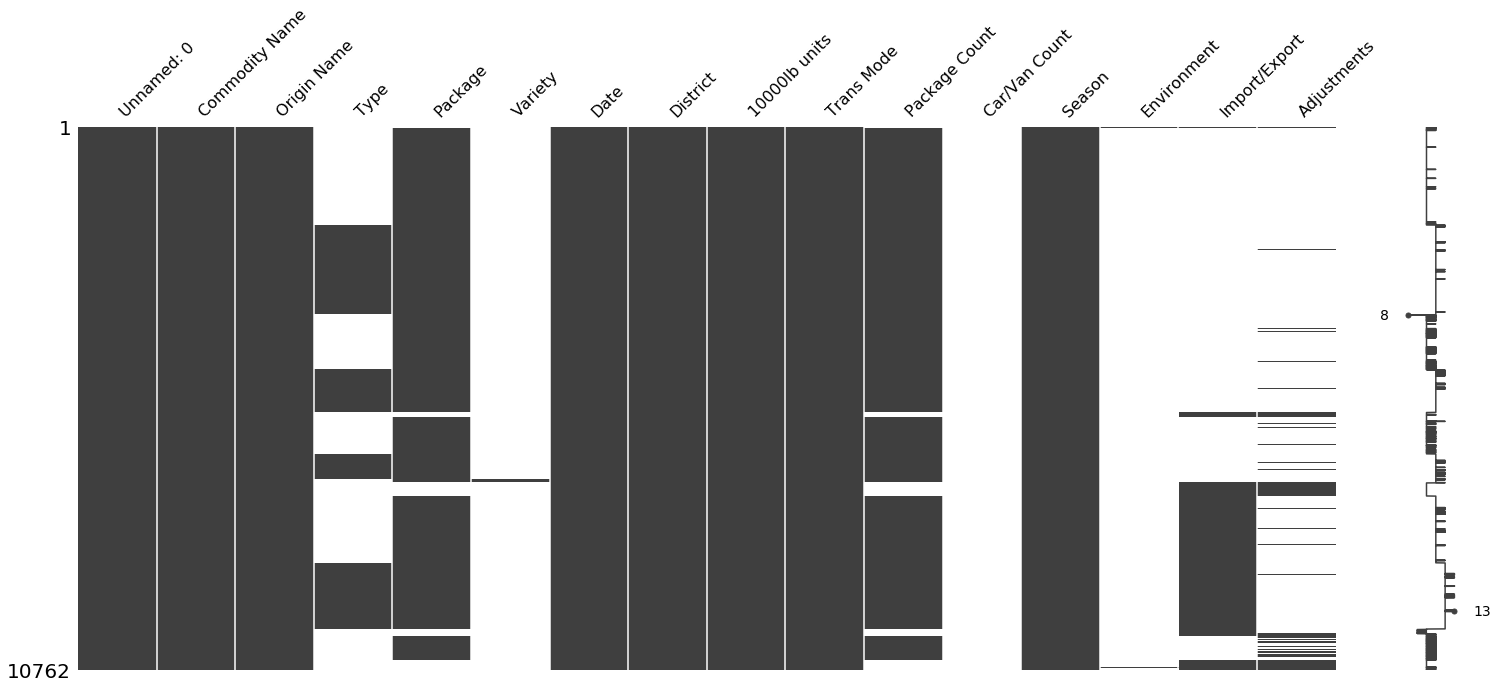

In [114]:
import missingno as msno
msno.matrix(quantity)

In [115]:
quantity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10762 entries, 0 to 10761
Data columns (total 16 columns):
Unnamed: 0        10762 non-null int64
Commodity Name    10762 non-null object
Origin Name       10762 non-null object
Type              4434 non-null object
Package           10039 non-null object
Variety           69 non-null object
Date              10762 non-null datetime64[ns]
District          10762 non-null object
10000lb units     10762 non-null int64
Trans Mode        10762 non-null object
Package Count     10039 non-null float64
Car/Van Count     0 non-null float64
Season            10762 non-null int64
Environment       68 non-null object
Import/Export     3353 non-null object
Adjustments       1207 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(10)
memory usage: 1.3+ MB


In [116]:
quantity.groupby('Origin Name')['Date'].nunique()

Origin Name
ARGENTINA                6
BELGIUM                 18
CALIFORNIA-CENTRAL    1095
CALIFORNIA-SOUTH      1003
CANADA                  46
CHILE                   32
COLOMBIA                 3
FLORIDA                596
FRANCE                  33
GUATEMALA                2
JAPAN                   88
MEXICO                 739
MOROCCO                  3
NETHERLANDS             26
NEW ZEALAND              8
NORTH CAROLINA         233
PERU                    46
SOUTH KOREA             40
SPAIN                   56
TURKEY                   6
Name: Date, dtype: int64

In [117]:
quantity = quantity[(quantity['Origin Name']=='MEXICO') \
       & (quantity['10000lb units'].notnull())]

In [118]:
quantity['10000lb units'].sum()

111226

In [119]:
quantity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2724 entries, 7313 to 10036
Data columns (total 16 columns):
Unnamed: 0        2724 non-null int64
Commodity Name    2724 non-null object
Origin Name       2724 non-null object
Type              1308 non-null object
Package           2631 non-null object
Variety           0 non-null object
Date              2724 non-null datetime64[ns]
District          2724 non-null object
10000lb units     2724 non-null int64
Trans Mode        2724 non-null object
Package Count     2631 non-null float64
Car/Van Count     0 non-null float64
Season            2724 non-null int64
Environment       0 non-null object
Import/Export     2724 non-null object
Adjustments       110 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(10)
memory usage: 361.8+ KB


### Cleanance

In [120]:
quantity = quantity[quantity['Type'] != 'Organic']

In [121]:
quantity_complete = quantity.groupby(['Date'])['10000lb units'].agg('sum').reset_index()

In [122]:
quantity_complete.set_index('Date',inplace=True)

In [123]:
quantity_complete.head()

,10000lb units
Date,
2017-01-01,192
2017-01-02,233
2017-01-03,192
2017-01-04,222
2017-01-05,208


In [124]:
quantity_complete.shape

(734, 1)

### Join prices and quantities

In [125]:
prices_complete.shape

(1213, 3)

In [126]:
df = prices_complete.join(quantity_complete)

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled checked> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled checked> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled checked> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled checked> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

In [127]:
df = df.fillna(0)

In [128]:
df['Kg'] = df['10000lb units']*lb_to_kg*10000

In [129]:
df['USDKg'] = df['Avg Price']/conv_package_un

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled checked> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled checked> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled checked> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled checked> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled checked> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled> Add price*quantity to value imports</li>
</ul>

In [130]:
df ['USD'] = df['Kg'] * df['USDKg'] 

<ul>
<li><input type="checkbox" disabled checked> Keep only imports from Mexico
<li><input type="checkbox" disabled checked> Unified prices, 'Mostly' average or 'Price' average instead</li>
<li><input type="checkbox" disabled checked> Add empty days with nearest available price</li>
<li><input type="checkbox" disabled checked> Summarize/Delete duplicates</li>
<li><input type="checkbox" disabled checked> Join import quantities data, summarized by day and apply zero if there is no data</li>
<li><input type="checkbox" disabled checked> Convert quantities to Kg and prices to USD-Kg</li>
<li><input type="checkbox" disabled checked> Add price*quantity to value imports</li>
</ul>

In [131]:
df['Commodity']=crop

In [132]:
df.to_excel(f'./Results/{crop}/resultpricesquantity.xlsx')

In [133]:
prices['USDKg'] = prices['Avg Price']/conv_package_un
prices['Commodity']=crop

In [134]:
prices.to_excel(f'./Results/{crop}/prices.xlsx')

### Plotting

In [135]:
prices['Avg Price Kg'] = prices['Avg Price']/(conv_package_un)
quantity_complete['Kg'] = quantity_complete['10000lb units']*lb_to_kg*10000
quantity_complete['Tn'] = quantity_complete['10000lb units']*lb_to_kg*10

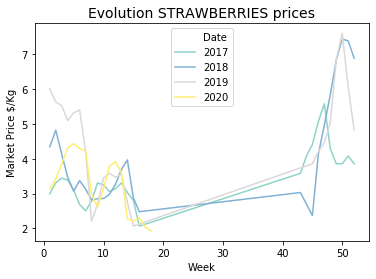

In [136]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import datetime

plot_prices = prices.resample('W').mean()
ax = sns.lineplot(x = plot_prices.index.week,
                  y = plot_prices['Avg Price Kg'],
                  hue = plot_prices.index.year,
                  data = plot_prices, palette = "Set3")
plt.title(f'Evolution {crop} prices', fontsize=14)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Market Price $/Kg', fontsize=10)
plt.savefig(f'./Results/{crop}/Evolution_{crop}_US.png')
plot_prices['Week_Num']=plot_prices.index.week
plot_prices.groupby('Week_Num').agg('count')
plt.show()

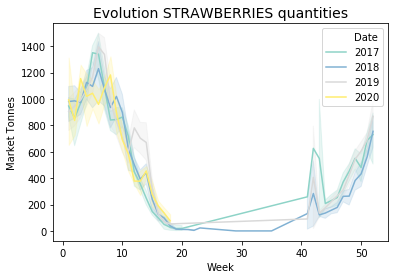

In [137]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import datetime

ax = sns.lineplot(x = quantity_complete.index.week,
                  y = quantity_complete['Tn'],
                  hue = quantity_complete.index.year,
                  data = quantity_complete, palette = "Set3")
plt.title(f'Evolution {crop} quantities', fontsize=14)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Market Tonnes', fontsize=10)
plt.savefig(f'./Results/{crop}/Evolution_{crop}_US_Kg.png')
quantity_complete['Week_Num']=quantity_complete.index.week
quantity_complete.groupby('Week_Num').agg('count')
plt.show()

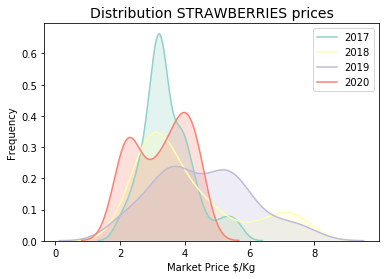

In [138]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

plot_prices_na = plot_prices.fillna(-1)

with sns.color_palette("Set3",10):
    ax = sns.kdeplot(prices['Avg Price Kg'].truncate(after='2018',before='2017'),label='2017', shade=True)
    ax = sns.kdeplot(prices['Avg Price Kg'].truncate(after='2019',before='2018'),label='2018', shade=True)
    ax = sns.kdeplot(prices['Avg Price Kg'].truncate(after='2020',before='2019'),label='2019', shade=True)
    ax = sns.kdeplot(prices['Avg Price Kg'].truncate(after='2021',before='2020'),label='2020', shade=True)
    plt.title(f'Distribution {crop} prices', fontsize=14)
    plt.xlabel('Market Price $/Kg', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.savefig(f'./Results/{crop}/Distribution_{crop}_US.png')
    plt.show()

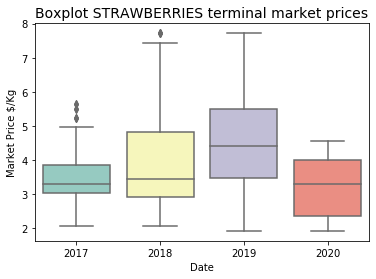

In [139]:
ax = sns.boxplot(x=prices.index.year,
                 y=prices['Avg Price Kg'],
                 data=prices, palette="Set3")
plt.title(f'Boxplot {crop} terminal market prices', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Market Price $/Kg', fontsize=10)
plt.savefig(f'./Results/{crop}/Boxplot_{crop}_US.png')
plt.show()

In [140]:
quantity_complete['Tn'].groupby(quantity_complete.index.year).sum()

Date
2017    116464.28192
2018    112146.08608
2019    124252.45656
2020     83179.70096
Name: Tn, dtype: float64

In [141]:
prices['Avg Price Kg'].groupby(prices.index.year).describe().transpose().to_excel(f'./Results/{crop}/summary.xlsx')

In [142]:
prices_w = prices.resample('W').mean()
prices_w['Week'] = prices_w.index.week
prices_w['Year'] = prices_w.index.year
prices_w[prices_w['Week'] == prices_w.tail(1)['Week'][0]-1][['Avg Price Kg','Week','Year']]\
.to_excel(f'./Results/{crop}/last_price.xlsx')